# APS 3

___

####  <font style='font-family:Georgia' color='darkturquoise'> Arthur

### Importando bibliotecas e valores

In [4]:
from funcoesTermosol import *
import numpy as np
import math
from time import perf_counter

In [5]:
def matprint(mat, fmt="g"):        # Credits to braingineer https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

### Representação da estrutura

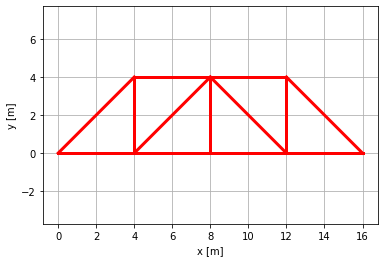

In [6]:
entrada = "aps3_entrada.xlsx"

[nn,N,nm,Inc,nc,F,nr,R] = importa(entrada)

plota(N, Inc)
# geraSaida()

### Informações sobre a treliça

* nn: número de nós
* N: Matriz dos nós
* nm: número de membros
* Inc: Matriz de incidência. Colunas:
    1. Nó 1
    2. Nó 2
    3. E
    4. A
* nc: número de cargas
* F: forças (Vetor carregamento)
* nr: número de restrições
* R: Restrições (Vetor com os graus de liberdade)

In [7]:
# Comprimento 
L = 4
#numero de nodes
n = 8

### Gerando a matriz de conectividade transposta

In [8]:
C = []
for i in range(nm):
        C_i = nn*[0]

        no_1 = int(Inc[i, 0])
        no_2 = int(Inc[i, 1])

        C_i[no_1-1] = -1
        C_i[no_2-1] = 1
        C.append(C_i) 

C_t = np.array(C).T
matprint(C_t)

-1   0   0   0  -1   0   0   0   0   0   0   0   0  
 1  -1   0   0   0   1  -1   0   0   0   0   0   0  
 0   1  -1   0   0   0   0   1   0   0   0   0   0  
 0   0   1  -1   0   0   0   0   1  -1   0   0   0  
 0   0   0   1   0   0   0   0   0   0   1   0   0  
 0   0   0   0   1  -1   0   0   0   0   0  -1   0  
 0   0   0   0   0   0   1  -1  -1   0   0   1  -1  
 0   0   0   0   0   0   0   0   0   1  -1   0   1  


### Matriz dos membros (M)

In [9]:
M = np.matmul(N, C_t)
print(M)

[[ 4.  4.  4.  4.  4.  0.  4.  0.  4.  0.  4.  4.  4.]
 [ 0.  0.  0.  0.  4. -4.  4. -4. -4.  4. -4.  0.  0.]]


### Obtendo Se, Ke e Kg

In [10]:
len_linhas_M = len(M)
len_linhas_C = len(C_t)
Kg = np.zeros((nn*2, nn*2))
for i in range(0, nm):
    E = Inc[i,2]
    A = Inc[i,3]
    
    n1 = Inc[i,0]
    n2 = Inc[i,1]
    
    x1 = N[0][int(Inc[:,0][i])-1]
    y1 = N[1][int(Inc[:,0][i])-1]
    x2 = N[0][int(Inc[:,1][i])-1]
    y2 = N[1][int(Inc[:,1][i])-1]    
    
    L = math.sqrt(((x1-x2)**2+(y1-y2)**2))
    
    const = E*A/L
    
    M_aux = M[:,i]
    M_aux.shape = [len_linhas_M, 1]
    M_aux2 = np.transpose(M_aux)
    Se = (const * np.matmul(M_aux, M_aux2)) / (np.linalg.norm(M[:,i])**2)

    C_aux = C_t[:,i]
    C_aux.shape = [len_linhas_C, 1]
    C_aux2 = np.transpose(C_aux)
    
    multi_C_aux = np.matmul(C_aux, C_aux2)
    Ke = np.kron(multi_C_aux, Se)
    Kg += Ke
# print(Se)
print(Kg)

[[ 1.59888494e+09  4.17634943e+08 -1.18125000e+09  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -4.17634943e+08 -4.17634943e+08
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.17634943e+08  4.17634943e+08  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -4.17634943e+08 -4.17634943e+08
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.18125000e+09  0.00000000e+00  2.78013494e+09  4.17634943e+08
  -1.18125000e+09  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -4.17634943e+08 -4.17634943e+08  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  4.17634943e+08  1.59888494e+09
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.18125000e+09
  -4.17

### Deslocamento nodal

Aplicando as condições de contorno para a matriz das forças:

In [11]:
F_c = np.delete(F, R.astype(int))
F_c


array([     0.,      0.,      0.,      0.,      0., -32000.,      0.,
       -48000.,      0., -32000.])

Aplicando as condições de contorno para a matriz da rigidez:

In [12]:
Kg_c = np.delete(Kg, R.astype(int),0)
Kg_c = np.delete(Kg_c, R.astype(int), 1)
matprint(Kg_c)

 2.78013e+09  -1.18125e+09             0             0             0            0  -4.17635e+08  -4.17635e+08             0             0  
-1.18125e+09    2.3625e+09             0  -1.18125e+09             0            0             0             0             0             0  
           0             0   1.18125e+09             0             0            0             0  -1.18125e+09             0             0  
           0  -1.18125e+09             0   2.78013e+09             0            0  -4.17635e+08   4.17635e+08             0             0  
           0             0             0             0   1.59888e+09  4.17635e+08  -1.18125e+09             0             0             0  
           0             0             0             0   4.17635e+08  1.59888e+09             0             0             0             0  
-4.17635e+08             0             0  -4.17635e+08  -1.18125e+09            0   3.19777e+09             0  -1.18125e+09             0  
-4.17635e+08        

___
**Funções de Jacobi e Gauss-Seidel utilizadas na aula 21:**

In [13]:
# def jacobi(k,F,ite,tol):
#     #inicializando X com 
#     x = np.zeros(k.shape[0])

#     # Cria um vetor com os elementos da diagonal de k                       
#     diagonal = np.diag(k)
#     # Subtrai a diagonal de K
#     k_d = k - np.diagflat(diagonal)
#     # loop até chegar abaixo da tolerância ou passar do número máximo de iterações
#     for i in range(ite):
#         x2 = (F - np.matmul(k_d,x)) / diagonal
#         error =  max(abs((x2 - x)/x2) )
#         if error < tol:
#             print(f"Erro máximo: {error}")
#             print(f"Convergiu na iteração: {i}")
#             return x2
        
#         x = x2
#     return x
def jacobi(K,F,ite,tol):
    if type(K) != list:
        U = np.zeros((K.shape[0],1))
        n = K.shape[0]
    else:
        U = np.zeros((len(K),1))
        n = len(K)
    U_ = U.copy()
    count = 0
    while count < ite:
        for i in range(n):
            U_[i][0] = F[i]
            for j in range(n):
                if j != i:
                    U_[i][0] -= K[i][j] * U[j][0]
            U_[i][0] /= K[i][i]

        if 0 not in U:     # Cálculo do erro
            ERROR_list = []
            for i,j in zip(U_,U):
                ERROR_list.append(abs((i-j)/j))
            ERRO = max(ERROR_list)
            if ERRO < tol:
                print("Iterações: {0}".format(count))
                return U;
        U = U_.copy() 
        count += 1
    print("Iterações: {0}".format(count))
    return U;

In [14]:
# def gauss_seidel(A, b, ite, tol):
#     x = np.zeros_like(b, dtype=np.double)
    
#     #Iterate
#     for k in range(ite):
        
#         x_old  = x.copy()
        
#         #Loop over rows
#         for i in range(A.shape[0]):
#             x[i] = (b[i] - np.dot(A[i,:i], x[:i]) - np.dot(A[i,(i+1):], x_old[(i+1):])) / A[i ,i]
            
#         #Stop condition 
#         if np.linalg.norm(x - x_old, ord=np.inf) / np.linalg.norm(x, ord=np.inf) < tol:
#             break
            
#     return x
def gauss_seidel(K,F,ite,tol):
    if type(K) != list:
        U = np.zeros((K.shape[0],1))
        n = K.shape[0]
    else:
        U = np.zeros((len(K),1))
        n = len(K)
    U_ = U.copy()
    count = 0
    while count < ite:
        for i in range(n):
            U_[i][0] = F[i]
            for j in range(n):
                if j != i:
                    U_[i][0] -= K[i][j] * U_[j][0]
            U_[i][0] /= K[i][i]

        if 0 not in U:     # Cálculo do erro
            ERROR_list = []
            for i,j in zip(U_,U):
                ERROR_list.append(abs((i-j)/j))
            ERRO = max(ERROR_list)
            if ERRO < tol:
                print("Iterações: {0}".format(count))
                return U;
        U = U_.copy() 
        count += 1
    print("Iterações: {0}".format(count))
    return U;

___
Utilizando Jacobi, Gauss-Seidel e a forma geral para cálculo da matriz **U**

In [15]:
u_jacobi = jacobi(Kg_c, F_c, 1000, 1e-5)
print("Método Jacobi:")
timer_start = perf_counter()
matprint(jacobi(Kg_c, F_c,1000, 1e-5))
print("Tempo: {0}".format(perf_counter() - timer_start))

Iterações: 1000
Método Jacobi:
Iterações: 1000
-1.01587e-05  
           0  
-6.76252e-05  
 1.01587e-05  
 5.61051e-06  
-2.14794e-05  
           0  
-6.76252e-05  
-5.61051e-06  
-2.14794e-05  
Tempo: 0.074639572999331


In [16]:
u_gauss = gauss_seidel(Kg_c, F_c, 1000, 1e-5)
print("Método Gauss-Seidel:")
timer_start = perf_counter()
matprint(gauss_seidel(Kg_c, F_c, 1000, 1e-5))
print("Tempo: {0}".format(perf_counter() - timer_start))

Iterações: 101
Método Gauss-Seidel:
Iterações: 101
-1.01587e-05  
-2.30983e-21  
-6.76252e-05  
 1.01587e-05  
 5.61051e-06  
-2.14794e-05  
-2.55974e-21  
-6.76252e-05  
-5.61051e-06  
-2.14794e-05  
Tempo: 0.010982079000314116


**Deslocamentos nodais**

In [17]:
U_ar = np.linalg.solve(Kg_c, F_c)
U_ar

array([-1.01587302e-05,  0.00000000e+00, -6.76251860e-05,  1.01587302e-05,
        5.61051174e-06, -2.14794353e-05,  6.91800873e-22, -6.76251860e-05,
       -5.61051174e-06, -2.14794353e-05])

**Ajustando o tamanho das matrizes U**

In [18]:
u_jacobi_ajustado = np.zeros((nn*2,1))
i = 0
for e in range(len(u_jacobi_ajustado)):
    if e not in R:
        u_jacobi_ajustado[e] += u_jacobi[i]
        i += 1
u_jacobi_ajustado

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [-1.01587302e-05],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-6.76251860e-05],
       [ 1.01587302e-05],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 5.61051174e-06],
       [-2.14794353e-05],
       [ 0.00000000e+00],
       [-6.76251860e-05],
       [-5.61051174e-06],
       [-2.14794353e-05]])

In [19]:
u_gauss_ajustado = np.zeros((nn*2,1))
i = 0
for e in range(len(u_gauss_ajustado)):
    if e not in R:
        u_gauss_ajustado[e] += u_gauss[i]
        i += 1
u_gauss_ajustado

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [-1.01587302e-05],
       [ 0.00000000e+00],
       [-2.30982781e-21],
       [-6.76251860e-05],
       [ 1.01587302e-05],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 5.61051174e-06],
       [-2.14794353e-05],
       [-2.55973776e-21],
       [-6.76251860e-05],
       [-5.61051174e-06],
       [-2.14794353e-05]])

In [20]:
u = np.zeros((nn*2,1))
i = 0
for e in range(len(u)):
    if e not in R:
        u[e] += U_ar[i]
        i += 1
u

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [-1.01587302e-05],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-6.76251860e-05],
       [ 1.01587302e-05],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 5.61051174e-06],
       [-2.14794353e-05],
       [ 6.91800873e-22],
       [-6.76251860e-05],
       [-5.61051174e-06],
       [-2.14794353e-05]])

### Reações de apoio

In [21]:
P = np.matmul(Kg,u)
P

array([[ 1.86274170e+04],
       [ 6.62741700e+03],
       [-3.63797881e-12],
       [ 4.93725830e+04],
       [-7.35983242e-13],
       [-1.68160212e-12],
       [ 3.63797881e-12],
       [ 4.93725830e+04],
       [-1.86274170e+04],
       [ 6.62741700e+03],
       [ 0.00000000e+00],
       [-3.20000000e+04],
       [ 2.45500359e-12],
       [-4.80000000e+04],
       [ 0.00000000e+00],
       [-3.20000000e+04]])

In [22]:
P_r = np.zeros((nr,1))
for i in range(nr):  
    index = int(R[i])
    P_r[i] = P[index]    
P_r

array([[ 18627.41699797],
       [  6627.41699797],
       [ 49372.58300203],
       [ 49372.58300203],
       [-18627.41699797],
       [  6627.41699797]])

### Deformações, Tenões e Forças internas

In [23]:
deformacoes=[]
tensoes=[]
forcas=[]
for i in range (nm):
        
    matriz = [
            u[(int(Inc[i, 0])-1)*2], 
            u[(int(Inc[i, 0])-1)*2 +1], 
            u[(int(Inc[i, 1])-1)*2], 
            u[int(Inc[i, 1]-1)*2 +1]
    ]
    
    x1 = N[0][int(Inc[:,0][i])-1]
    y1 = N[1][int(Inc[:,0][i])-1]
    x2 = N[0][int(Inc[:,1][i])-1]
    y2 = N[1][int(Inc[:,1][i])-1]    
    
    L = math.sqrt(((x1-x2)**2+(y1-y2)**2))  
    
    E =  Inc[i, 2]
    A = Inc[i,3]
    const = E*A/L
    
    s = (y2-y1)/L
    c = (x2-x1)/L
    
    C = [-c, -s, c, s]

    deformacao = (1/L) * np.matmul(C, matriz)
    tensao = deformacao*E
    forca=tensao*A
    
    deformacoes.append(deformacao)
    tensoes.append(tensao)
    forcas.append(forca)



In [24]:
deformacoes

[array([-2.53968254e-06]),
 array([2.53968254e-06]),
 array([2.53968254e-06]),
 array([-2.53968254e-06]),
 array([-1.98361545e-06]),
 array([-5.36985884e-06]),
 array([-7.18330698e-06]),
 array([0.]),
 array([-7.18330698e-06]),
 array([-5.36985884e-06]),
 array([-1.98361545e-06]),
 array([-1.40262794e-06]),
 array([-1.40262794e-06])]

In [25]:
tensoes

[array([-533333.33333333]),
 array([533333.33333333]),
 array([533333.33333333]),
 array([-533333.33333333]),
 array([-416559.24453469]),
 array([-1127670.3556458]),
 array([-1508494.4665313]),
 array([0.]),
 array([-1508494.4665313]),
 array([-1127670.3556458]),
 array([-416559.24453469]),
 array([-294551.86657642]),
 array([-294551.86657642])]

In [26]:
forcas

[array([-12000.]),
 array([12000.]),
 array([12000.]),
 array([-12000.]),
 array([-9372.58300203]),
 array([-25372.58300203]),
 array([-33941.12549695]),
 array([0.]),
 array([-33941.12549695]),
 array([-25372.58300203]),
 array([-9372.58300203]),
 array([-6627.41699797]),
 array([-6627.41699797])]

___
**Gerando Saídas com as 3 matrizes U calculadas anteriormente**

In [27]:
x = geraSaida("geral", P_r, u, deformacoes, forcas, tensoes)

In [28]:
geraSaida("jacobi", P_r, u_jacobi_ajustado, deformacoes, forcas, tensoes)

In [29]:
geraSaida("gauss", P_r, u_gauss_ajustado, deformacoes, forcas, tensoes)